# Tutorial 1: Training a pairwise genotype-phenotype map on splicing data.

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# For showing images
from IPython.display import Image

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn

In this tutorial we will train a genotype-phenotype (G-P) map on data from a massivley parallel splicing assay (MPSA) performed by Wong et al., 2018. Wong et al. mesured splicing activity for nearly all 5' splice sites of the form 'NNN/GYNNNN', where 'Y' denotes any pyrimidine ('C' or 'U'), and '/' denotes the exon/intron boundary.  This was accomplished using the experimental setup illustrated in the following figure. 

<img src="fig_tutorial1_fig1.png" alt="MPSA experiment" style="width: 600px;"/>

Specifically, the authors used a minigene expression system where each variant 5' splice site was tagged with a 20 nucleotide barcode. Constructs were transfected into cell culture, and the fraction of processed transcripts containing the central exon (which the variant 5' splice sites flank). The resulting dataset conisted of a list of assayed splice sites, each assigned a percent-spliced-in (PSI) value. Our goal is to model log PSI values as a function of sequence. 

We begin by loading data from this assay. This is provided as an example dataset within MAVE-NN, and can be loaded as follows.

In [2]:
# Load data as a pandas DataFrame
data_df = mavenn.load_example_dataset('mpsa')

# Show dataset size
print(f'Number of splice sites assayed: {len(data_df):,d}.')

# Preview dataset
data_df.head()

Number of splice sites assayed: 30,483.


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,315,7,-0.587914,AGUGUGCAA
2,test,193,15,-0.074999,UUCGCGCCA
3,validation,27,0,-0.438475,UAAGCUUUU
4,training,130,2,-0.631467,AUGGUCGGG


In this dataset, $x$ denotes splice site sequences and $y$ denotes log PSI values (which the experiment determins up to an uncertain additive shift). We next extract the data from this dataframe and split into training and test sets. 

In [3]:
# Extract x and y as Numpy arrays
x = data_df['x'].values
y = data_df['y'].values

# indices of training examples
i_training = data_df['set']=='training'

# get train examples.
mpsa_train_df = data_df[i_training]
# get test examples.
mpsa_test_df = data_df[~i_training]

x_train, y_train  = mpsa_train_df['x'], mpsa_train_df['y']
x_test, y_test  = mpsa_test_df['x'], mpsa_test_df['y']

# Show dataset sizes
print(f'Training set size: {len(x_train):6,d} observations')
print(f'Test set size    : {len(x_test):6,d} observations')

Training set size: 18,215 observations
Test set size    : 12,268 observations


Next we define a MAVE-NN model.


In [4]:
# Define model and set training data
model = mavenn.Model(regression_type='GE',
                     L=len(x[0]),
                     alphabet='rna',
                     gpmap_type='pairwise',                     
                     ge_noise_model_type='Gaussian',
                     ge_heteroskedasticity_order=2)

The overall form of this model is schematized in the following figure.

<img src="fig_tutorial1_fig2.png" alt="Modeling assumptions" style="width: 600px;"/>

In addition to specifying the training inputs (`x=x_train`) and training labels (`y=y_train`), five additional parameters are set. 

`alphabet='rna'`: This indicates that sequences are made up of the characters 'A', 'C', 'G', 'U'. 

`gpmap_type='pairwise'`: This indicates that we want to fit a pairwise model for the latent phenotype $\phi$, i.e. a model of the mathematical form

$$ \phi(x) = \theta_0 + \sum_{l,c} \theta_{l:c} x_{l:c} + \sum_{l,l'>l} \sum_{c,c'} \theta_{l:c,l':c'} x_{l:c} x_{l':c'}$$

where $l$ indexes positions in the sequence, $c$ indexes characters from the alphabet, and $x_{l:c}$ is an indicator variable equal to 1 when $c$ occurs at position $l$, and equal to 0 otherwise. The parameters of this model $\theta_0, \theta_{l:c}, \theta_{l:c,l':c'}$ are to be learned from data. 

`regression_type='GE'`: This indicates that we want to perform global epistasis (GE) regression. The key assumption of GE regression is that each measurement $y$ is a noisy readout of a predicte mesurement $\hat{y}$, which itself is a nonlinear function $g$ of the latent phenotype $\phi$. Thus,

$$ p(y | \phi) = p(y|\hat{y})~~\mathrm{where}~~\hat{y} = g(\phi).$$

The nonlinear function $g(\phi)$ is to be learned from data using a two-layer neural network having a default value of `ge_nonlinearity_hidden_nodes=50` hidden nodes. 

`ge_noise_model_type='Gaussian'`: This indicates that we wish for our noise model, $p(y|\hat{y})$, to be a Gaussian distribution. 

`ge_heteroskedasticitiy_order=2`: This indicates that we are using a heteroskedastic model. Specifically, we model the standard deviation $s$ of $p(y|\hat{y})$  an expoentiated quadratic polynomial in $\hat{y}$,

$$ s(\hat{y}) = \exp \left[ a_0 + a_1 \hat{y} + a_2 \hat{y}^2 \right], $$

where the coefficients $a_0, a_1, a_2$ are to be learned from data. 

To fit this model to training data, we do the following.

In [5]:
# set data
model.set_data(x=x_train,
               y=y_train)

N = 18,215 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 0.336 sec.


In [6]:
# Start timer
import time
start_time = time.time()

# Fit model to training data. Takes ~30 seconds.
model.fit(epochs=1000, 
          learning_rate=.005, 
          verbose=True, 
          batch_size=200,
          early_stopping=True,
          early_stopping_patience=20)

# Report fitting time
training_time = time.time()-start_time
print(f'Inference time: {training_time:.2f} seconds')

 
LSMR            Least-squares solution of  Ax = b

The matrix A has    14589 rows  and       36 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.214e+02  3.571e+03   1.0e+00  2.4e-01
     1 -8.96194e-04  1.103e+02  1.179e+03   9.1e-01  1.5e-01  7.0e+01  1.0e+00
     2 -9.47067e-04  1.092e+02  7.450e+02   9.0e-01  6.4e-02  1.1e+02  1.0e+00
     3  2.23814e-03  1.089e+02  5.047e+01   9.0e-01  1.9e-03  2.4e+02  2.2e+00
     4  3.56602e-03  1.089e+02  2.517e+00   9.0e-01  9.3e-05  2.5e+02  2.7e+00
     5  3.53282e-03  1.089e+02  1.792e-01   9.0e-01  6.4e-06  2.6e+02  2.7e+00
     6  3.53430e-03  1.089e+02  1.588e-02   9.0e-01  5.6e-07  2.6e+02  2.9e+00
 
LSMR finished
The least-squares solution is good enough, given atol     
istop =       2    normr = 1.1e+02
    normA = 2.6e+02    normAr = 1.6e-02
itn

Epoch 51/1000
73/73 [==============================] - 0s 2ms/step - loss: 155.2816 - I_var: 0.2827 - val_loss: 157.4036 - val_I_var: 0.2747
Epoch 52/1000
73/73 [==============================] - 0s 2ms/step - loss: 155.2470 - I_var: 0.2830 - val_loss: 156.7480 - val_I_var: 0.2789
Epoch 53/1000
73/73 [==============================] - 0s 2ms/step - loss: 156.0323 - I_var: 0.2773 - val_loss: 156.9212 - val_I_var: 0.2776
Epoch 54/1000
73/73 [==============================] - 0s 2ms/step - loss: 155.4794 - I_var: 0.2815 - val_loss: 159.5945 - val_I_var: 0.2611
Epoch 55/1000
73/73 [==============================] - 0s 3ms/step - loss: 156.1099 - I_var: 0.2768 - val_loss: 159.7247 - val_I_var: 0.2572
Epoch 56/1000
73/73 [==============================] - 0s 2ms/step - loss: 155.7538 - I_var: 0.2798 - val_loss: 155.9923 - val_I_var: 0.2848
Epoch 57/1000
73/73 [==============================] - 0s 2ms/step - loss: 155.2220 - I_var: 0.2836 - val_loss: 156.7297 - val_I_var: 0.2789
Epoch 58/1000

Let's visualize the results:

On test data:
I_var_test: 0.283 +- 0.018 bits
I_pred_test: 0.372 +- 0.008 bits


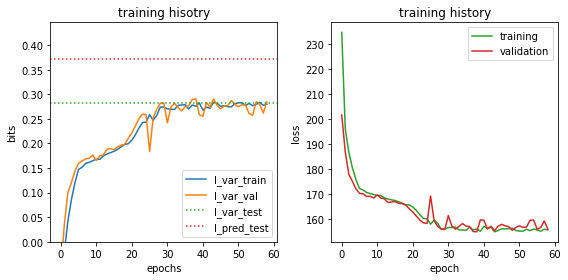

In [7]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

# Extract training loss and validation loss
loss_training = model.history['loss']
loss_validation = model.history['val_loss']

fig, ax = plt.subplots(1,2,figsize=[8,4])

ax[0].plot(I_var_hist, label='I_var_train')
ax[0].plot(val_I_var_hist, label='I_var_val')
ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('bits')
ax[0].set_title('training hisotry')
ax[0].set_ylim([0, I_pred*1.2]);

ax[1].plot(loss_training, color='C2', label='training')
ax[1].plot(loss_validation, color='C3', label='validation')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].set_title(f"training history")
ax[1].legend()
plt.tight_layout()

To assess model performance, we compute the correlation between $\hat{y}$ and $y$ on training data. To get values for $\hat{y}$, we use the method `model.x_to_yhat()`, which returns a numpy array the same shape as its input.

In [8]:
# Predict measurement values (yhat) from sequence (x)
yhat_test = model.x_to_yhat(x_test)
print(f'yhat_test: {repr(yhat_test)}')

yhat_test: array([-0.3175105 , -0.3208193 , -0.2229658 , ..., -0.31523383,
       -0.28031987, -0.37740254], dtype=float32)


Next we plot $y$ against $\hat{y}$ and compute the corresponding $R^2$ value.

Text(0.5, 1.0, 'performance ($R^2$=0.696)')

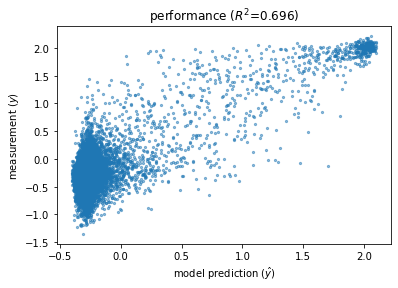

In [9]:
# Compute R^2 between yhat and y_test
Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

# Plot y_test vs. yhat_test
fig, ax = plt.subplots(1,1)
ax.scatter(yhat_test, y_test, color='C0', s=5, alpha=.5, label='test data')
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'performance ($R^2$={Rsq:.3})')

Note that instead of using `model.x_to_yhat()`, we can alternatively use `model.x_to_phi()` to first predict latent phenotype values $\phi$ from input sequences $x$, then use these $\phi$ to compute $\hat{y}$ values via `model.phi_to_yhat()`:

In [10]:
# Predict latent phenotype values (phi) from sequence (x)
phi_test = model.x_to_phi(x_test)
print(f'phi_test: {repr(phi_test)}')

# Predict measurement values (yhat) from latent phenotype (phi)
yhat_test = model.phi_to_yhat(phi_test)
print(f'yhat_test: {repr(yhat_test)}')

phi_test: array([-0.78413916, -0.85197663,  0.6084505 , ..., -0.7379591 ,
       -0.08993081, -2.1401722 ], dtype=float32)
yhat_test: array([-0.3175105 , -0.3208193 , -0.2229658 , ..., -0.31523383,
       -0.28031987, -0.37740254], dtype=float32)


It is worth plotting measurements $y$ against the predicted latent phenotypes $\phi$. On the same plot we can show the nonlineairty $g(\phi)$ by creating a grid of $\phi$ values and mapping these to $\hat{y}$ values using `model.phi_to_yhat()`. When doing this, it often makes sense to further plot confidence intervals of $p(y|\hat{y})$ using the function `model.yhat_to_yq()`.

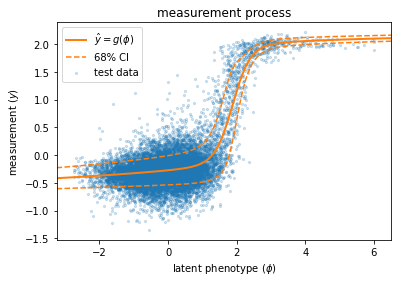

In [11]:
# Create a grid of phi values for plotting the GE nonlinearity
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat for each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 68% confidence interval in y for each value of yhat
yqs_grid = model.yhat_to_yq(yhat_grid, q=[0.16, 0.84])

# Create figure and axes
fig, ax = plt.subplots(1, 1)
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:,0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:,1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

Strong sigmoidal nonlinearities like the one we find here are very common on MAVE experiments and it is critically important that one account for them when trying to model G-P maps. Note also that, in this case, we find that the standard deviation of $y$ about $\hat{y}$ decreases at larger $\hat{y}$ values. This illustrates the utility of infering a heteroskedastic noise model. 

Ultimately we want to view the parameters of the G-P map. MAVE-NN provides two methods to support such visualization, `mavenn.heatmap()` and `mavenn.pairwise_heatmap()`. we retrieve the additive parameters $\theta_{l:c,l':c'}$ in dataframe format using `get_pairwise_parameters()`:

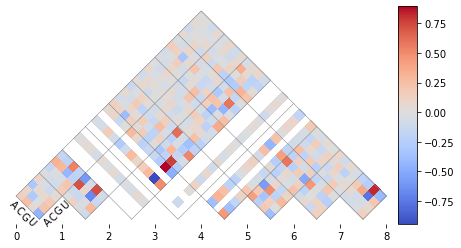

In [12]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                        alphabet=theta['alphabet'],
                        ax=ax);

We then draw thse using `mavenn.pairwise_heatmap()`, again with the specified mask in place. 

In [13]:
# Save model
model.save('tutorial_1_mpsa_ge_pairwise')

Model saved to these files:
	tutorial_1_mpsa_ge_pairwise.pickle
	tutorial_1_mpsa_ge_pairwise.h5
